![diffusers_library](https://github.com/huggingface/diffusers/raw/main/docs/source/en/imgs/diffusers_library.jpg)

*Introducing Hugging Face's new library for diffusion models*

Diffusion models proved themselves very effective in artificial synthesis, even beating GANs for images. Because of that, they gained traction in the machine learning community and play an important role for systems like [DALL-E 2](https://openai.com/dall-e-2/) or [Imagen](https://imagen.research.google/) to generate photorealistic images when prompted on text.

While the most prolific successes of diffusion models have been in the computer vision community, these models have also achieved remarkable results in other domains, such as:
- [video generation](https://video-diffusion.github.io/),
- [audio synthesis](https://diffwave-demo.github.io/),
- [reinforcement learning](https://diffusion-planning.github.io/),
- and more.

However, most of the recent research on diffusion models, *e.g.* DALL-E 2 and Imagen, is unfortunately not accessible to the broader machine learning community and typically remains behind closed doors.

Here comes the `diffusers` library with the goals to:

1. gather recent diffusion models from independent repositories in a single and **long-term maintained** project that is built by and for the **community**,
2. reproduce high impact machine learning systems such as DALLE and Imagen in a manner that is accessible for the public, and
3. create an easy to use API that enables one to train their own models or re-use checkpoints from other repositories for inference. 

This notebook will walk you through the most important features of `diffusers`.

We assume that the reader has a minimal understanding of how diffusion models function. To refresh some theory as well as terminology, we recommend reading/skimming the following blog posts:

  - Lilian Weng's, OpenAI, [introductory post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
  - Yang Song's, Stanford, [introductory post](https://yang-song.github.io/blog/2021/score/)
  - The Annotated Diffusion Model [post](https://huggingface.co/blog/annotated-diffusion)

Or papers:
- The original paper proposing [thermodynamics for unsupervised learning](https://arxiv.org/abs/1503.03585),
- The paper for a popular diffusion model, [Denoising Diffusion Probabilistic Models
 DDPM](https://arxiv.org/abs/2006.11239), or
- A recent paper covering [tradeoffs in diffusion models](https://arxiv.org/abs/2206.00364)

### Summary
This post is designed to showcase the core API of `diffusers`, which is divided into three components:
1. **Pipelines**: high-level classes designed to rapidly generate samples from popular trained diffusion models in a user-friendly fashion.
2. **Models**: popular architectures for training new diffusion models, *e.g.* [UNet](https://arxiv.org/abs/1505.04597).
3. **Schedulers**: various techniques for generating images from noise during *inference* as well as to generate noisy images for *training*.

**Note**: This notebook focus only on **inference**. If you want to get a more hands-on guide on **training** diffusion models, please have a look at the [*Training with Diffusers*](https://colab.research.google.com/gist/anton-l/f3a8206dae4125b93f05b1f5f703191d/diffusers_training_example.ipynb) notebook.

### Install `diffusers`

In [1]:
!pip install diffusers==0.11.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.7 MB/s eta 0:00:00


### Overview

One goal of the diffusers library is to make diffusion models accessible to a wide range of deep learning practitioners. 
With this in mind, we aimed at building a library that is **easy to use**, **intuitive to understand**, and **easy to contribute to**.

As a quick recap, diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*. 

The underlying model, often a neural network, is trained to predict a way to slightly denoise the image in each step. After certain number of steps, a sample is obtained.

The process is illustrated by the following design:
![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusion-process.png)

The architecture of the neural network, referred to as **model**, commonly follows the UNet architecture as proposed in [this paper](https://arxiv.org/abs/1505.04597) and improved upon in the Pixel++ paper.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

No worries if you don't understand everything. Some of the highlights of the architecture are:
* this model predicts images of the same size as the input
* the model makes the input image go through several blocks of ResNet layers which halves the image size by 2
* then through the same number of blocks that upsample it again.
* skip connections link features on the downsample path to corresponding layers in the upsample path. 


The diffusion process consists in taking random noise of the size of the desired output and pass it through the model several times. The process ends after a given number of steps, and the output image should represent a sample according to the training data distribution of the model, for instance an image of a butterfly. 

During training we show many samples of a given distribution, such as images of butterfly. After training, the model will be able to process random noise to generate similar butterfly images.

Without going in too much detail, the model is usually not trained to directly predict a slightly less noisy image, but rather to predict the "noise residual" which is the difference between a less noisy image and the input image (for a diffusion model called "DDPM") or, similarly, the gradient between the two time steps (like the diffusion model called "Score VE").

To do the denoising process, a specific noise scheduling algorithm is thus necessary and "wrap" the model to define how many diffusion steps are needed for inference as well as how to *compute* a less noisy image from the model's output. Here is where the different **schedulers** of the diffusers library come into play.

Finally, a **pipeline** groups together a **model** and a **scheduler** and make it easy for an end-user to run a full denoising loop process. We'll start with the pipelines and dive deeper into its implementation before taking a closer look at models and schedulers.

## Core API

### Pipelines

Let's begin by importing a pipeline. We'll use the `google/ddpm-celebahq-256` model, built in collaboration by Google and U.C.Berkeley. It's a model following the [Denoising Diffusion Probabilistic Models (DDPM) algorithm](https://arxiv.org/abs/2006.11239) trained on a dataset of celebrities images. 

We can import the `DDPMPipeline`, which will allow you to do inference with a couple of lines of code:

In [2]:
from diffusers import DDPMPipeline

The `from_pretrained()` method allows downloading the model and its configuration from [the Hugging Face Hub](https://huggingface.co/google/ddpm-celebahq-256), a repository of over 60,000 models shared by the community.


In [3]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to("cuda")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.11.1",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

To generate an image, we simply run the pipeline and don't even need to give it any input, it will generate a random initial noise sample and then iterate the diffusion process.

The pipeline returns as output a dictionary with a generated `sample` of interest. This will typically take 2-3 minutes on Google Colab:

In [4]:
images = image_pipe().images

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's take a look 🙂

In [6]:
images

[<PIL.Image.Image image mode=RGB size=256x256 at 0x7FE28C633220>]

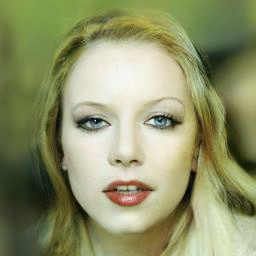

In [7]:
images[0]

Looks pretty good!

Now, let's try to understand a bit better what was going on under the hood. Let's see what the pipeline is made of:

In [8]:
image_pipe

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.11.1",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

We can see inside the pipeline a scheduler and a UNet model. Let's have a closer look at them and what this pipeline just did behind the scenes.

### Models

Instances of the model class are neural networks that take a noisy `sample` as well as a `timestep` as inputs to predict a less noisy output `sample`. Let's load a pre-trained model and play around with it to understand the model API!

We'll load a simple unconditional image generation model of type `UNet2DModel` which was released with the [DDPM Paper](https://arxiv.org/abs/2006.11239) and for instance take a look at another checkpoint trained on church images: [`google/ddpm-church-256`](https://huggingface.co/google/ddpm-church-256).

Similarly to what we've seen for the pipeline class, we can load the model configuration and weights with one line, using the `from_pretrained()` method that you may be familiar with if you've played with the `transformers` library:

In [11]:
from diffusers import UNet2DModel

repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


The `from_pretrained()` method caches the model weights locally, so if you execute the cell above a second time, it will go much faster. The model is a pure PyTorch `torch.nn.Module` class which you can see when printing out `model`.

In [12]:
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

Now let's take a look at the model's configuration. The configuration can be accessed via the `config` attribute and shows all the necessary parameters to define the model architecture (and only those).

In [13]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('act_fn', 'silu'),
            ('attention_head_dim', None),
            ('norm_num_groups', 32),
            ('norm_eps', 

As you can see, the model config is a frozen dictionary. This is to enforce that the configuration will **only** be used to define the model architecture at instantiation time and not for any attributes that can be changed during inference.

A couple of important config parameters are:
- `sample_size`: defines the `height` and `width` dimension of the input sample.
- `in_channels`: defines the number of input channels of the input sample.
- `down_block_types` and `up_block_types`: define the type of down- and upsampling blocks that are used to create the UNet architecture as was seen in the figure at the beginning of this notebook.
- `block_out_channels`: defines the number of output channels of the downsampling blocks, also used in reversed order for the number of input channels of the upsampling blocks.
- `layers_per_block`: defines how many ResNet blocks are present in each UNet block.

Knowing how a UNet config looks like, you can quickly try to instantiate the exact same model architecture with random weights. To do so, let's pass the config as an unpacked dict to the `UNet2DModel` class.

In [15]:
# model with random weights
model_random = UNet2DModel(**model.config)

Cool, the above created a randomly initialized model with the same config as the previous one.

If you want to save the model you just created, you can use the `save_pretrained()` method, which saves both the model weights as well as the model config in the provided folder.

In [16]:
model_random.save_pretrained("my_model")

Let's take a look at what files were saved in `my_model`.

In [17]:
!ls my_model

config.json  diffusion_pytorch_model.bin


`diffusion_pytorch_model.bin` is a binary PyTorch file that stores the model weights and `config.json` stores the model's configuration. 

If you want to reuse the model, you can simply use the `from_pretrained()` method again, as it loads local checkpoints as well as those present on the Hub.

In [21]:
model_random = UNet2DModel.from_pretrained("my_model")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Coming back to the actually trained model, let's now see how you can use the model for inference. First, you need a random gaussian sample in the shape of an image (`batch_size` $\times$ `in_channels` $\times$ `sample_size` $\times$ `sample_size`). We have a `batch` axis because a model can receive multiple random noises, a `channel` axis because each one consists of multiple channels (such as red-green-blue), and finally `sample_size` corresponds to the height and width.

In [22]:
import torch

torch.manual_seed(0)

noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
)
noisy_sample.shape

torch.Size([1, 3, 256, 256])

Time to do the inference!

You can pass the noisy sample alongside a `timestep` through the model. The timestep is important to cue the model with "how noisy" the input image is (more noisy in the beginning of the process, less noisy at the end), so the model knows if it's closer to the start or the end of the diffusion process.

As explained in the introduction, the model predicts either the slightly less noisy image, the difference between the slightly less noisy image and the input image or even something else. It is important to carefully read through the [model card](https://huggingface.co/google/ddpm-church-256) to know what the model has been trained on. In this case, the model predicts the noise residual (difference between the slightly less noisy image and the input image).

In [23]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

The predicted `noisy_residual` has the exact same shape as the input and we use it to compute a slightly less noised image. Let's confirm the output shapes match:

In [24]:
noisy_residual.shape

torch.Size([1, 3, 256, 256])

Great.

Now to summarize, **models**, such as `UNet2DModel` (PyTorch modules) are parameterized neural networks trained to *predict* a slightly less noisy image or residual. They are defined by their `.config` and can be loaded from the Hub as well as saved and loaded locally. The next step is learning how to combine this **model** with the correct **scheduler** to be able to actually generate images.

### Schedulers

**Schedulers** are algorithms wrapped into a Python class. They define the noise schedule which is used to add noise to the model during training, and also define the algorithm to *compute* the slightly less noisy sample given the model output (here `noisy_residual`). This notebook focuses only on how to use *scheduler* classes for inference. You can check out this notebook to see how to use *schedulers* for training.

It is important to stress here that while *models* have trainable weights, *schedulers* are usually *parameter-free* (in the sense they have no trainable weights) and simply define the algorithm to compute the slightly less noisy sample. Schedulers thus don't inherit from `torch.nn.Module`, but like models they are instantiated by a configuration. 

To download a scheduler config from the Hub, you can make use of the `from_config()` method to load a configuration and instantiate a scheduler.

Let's use `DDPMScheduler`, the denoising algorithm proposed in the [DDPM Paper](https://arxiv.org/abs/2006.11239).

In [25]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_config(repo_id)

Let's also take a look at the config here.

In [26]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.1.1')])

Different schedulers are usually defined by different parameters. To better understand what the parameters are used for exactly, the reader is advised to directly look into the respective scheduler files under `src/diffusers/schedulers/`, such as the [`src/diffusers/schedulers/scheduling_ddpm.py`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddpm.py) file. Here are the most important ones:
- `num_train_timesteps` defines the length of the denoising process, e.g. how many timesteps are need to process random gaussian noise to a data sample.
- `beta_schedule` define the type of noise schedule that shall be used for inference and training
- `beta_start` and `beta_end` define the smallest noise value and highest noise value of the schedule.

Like the *models*, *schedulers* can be saved and loaded with `save_config()` and `from_config()`.



In [27]:
scheduler.save_config("my_scheduler")
new_scheduler = DDPMScheduler.from_config("my_scheduler")

All schedulers provide one or multiple `step()` methods that can be used to compute the slightly less noisy image. The `step()` method may vary from one scheduler to another, but normally expects at least the model output, the `timestep` and the current `noisy_sample`.

Note that the `step()` method is somewhat of a black box function that "just works". If you are keen to better understand how exactly the previous noisy sample is computed as defined in the original paper of the scheduler, you should take a look at the actual code, *e.g.* [click here](https://github.com/huggingface/diffusers/blob/936cd08488260a9df3548d66628b83bc7f26bd9e/src/diffusers/schedulers/scheduling_ddpm.py#L130) for DDPM, which contains comments and references to the original paper. 

Let's give it a try using the model output from the previous section.

In [28]:
less_noisy_sample = scheduler.step(
    model_output=noisy_residual, timestep=2, sample=noisy_sample
).prev_sample
less_noisy_sample.shape

torch.Size([1, 3, 256, 256])

You can see that the computed sample has the exact same shape as the model input, meaning that you are ready to pass it to the model again in a next step.

Let's now bring it all together and actually define the denoising loop. This loop prints out the (less and less) noisy samples along the way for better visualization in the denoising loop. Let's define a display function that takes care of post-processing the denoised image, convert it to a `PIL.Image` and displays it.

In [29]:
import PIL.Image
import numpy as np

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

Before defining the loop, let's move the input and model to the GPU to speed up the denoising process a bit.

In [30]:
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

Time to finally define the denoising loop! It is rather straight-forward for DDPM. 

1. Predict the residual of the less noisy sample with the model.
2. Compute the less noisy sample with the scheduler.

Additionally, at every 50th step this will display the progress.

It's important to note here that you loop over `scheduler.timesteps` which is a tensor defining the sequence of timesteps over which to iterate during the denoising process. Usually, the denoising process goes in decreasing order of timesteps, so from the total number of timesteps (here 1000) to 0.

Depending on your GPU this might take up to a minute - enough time to reflect on everything you learned so far while you can watch a church being built from nothing but noise ⛪.

In [31]:
import tqdm

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)

Output hidden; open in https://colab.research.google.com to view.

You can see that it takes quite some time to see a somewhat meaningful shape - only after *ca.* 800 steps. 

While the quality of the image is actually quite good - you might want to speed up the image generation.

To do so, you can try replacing the DDPM scheduler with the [DDIM](https://arxiv.org/abs/2010.02502) scheduler which keep high generation quality at significantly sped-up generation time.

**Exchanging schedulers**: one of the exciting prospects of a diffusion model library is that different scheduling protocols can work with different models, but there is not a one-sized fits all solution! 
In this case, DDIM worked as an swap for DDPM, but this not universal (and represents an interesting research problem).



The DDPM and DDIM scheduler more or less share the same configuration, so you can load a DDIM scheduler from a DDPM scheduler.

In [32]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler.from_config(repo_id)

The DDIM scheduler allows the user to define how many denoising steps should be run at inference via the `set_timesteps` method. The DDPM scheduler runs by default 1000 denoising steps. Let's significantly reduce this number to just 50 inference steps for DDIM.

In [33]:
scheduler.set_timesteps(num_inference_steps=50)

And you can run the same loop as before - only that you are now making use of the much faster DDIM scheduler.

 18%|█▊        | 9/50 [00:01<00:04,  8.67it/s]

'Image at step 10'

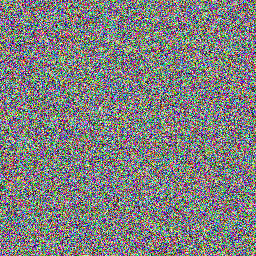

 38%|███▊      | 19/50 [00:02<00:03,  8.63it/s]

'Image at step 20'

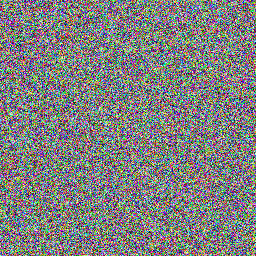

 58%|█████▊    | 29/50 [00:03<00:02,  8.56it/s]

'Image at step 30'

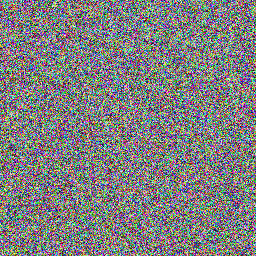

 78%|███████▊  | 39/50 [00:04<00:01,  8.67it/s]

'Image at step 40'

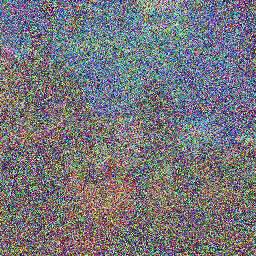

 98%|█████████▊| 49/50 [00:05<00:00,  8.68it/s]

'Image at step 50'

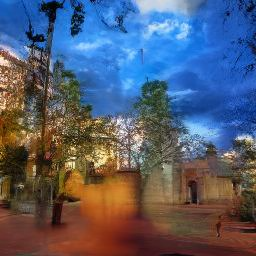

100%|██████████| 50/50 [00:06<00:00,  8.28it/s]


In [34]:
import tqdm

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute previous image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 10 == 0:
      display_sample(sample, i + 1)

You can see that the image generation is indeed much faster - a mere two seconds - but also that you pay by giving away image quality in exchange for speed.

Cool, now you should have gotten a good first understanding of the schedulers. The important things to remember are:
1. schedulers are *parameter-free* (no trainable weights)
2. schedulers define the algorithm computing the slightly less noisy sample during inference

They are many schedulers already added to `diffusers` and diffusers will be adding even more in the future. It's important that you read the model cards to understand which model checkpoints can be used with which schedulers.
You can find all available schedulers [here](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers).

To end the chapter about **models** and **schedulers**, please also note that we very much *deliberately* try to keep *models* and *schedulers* as independent from each other as possible. This means a `scheduler` should never accept a `model` as an input and vice-versa. The model *predict* the noise residual or slightly less noisy image with its trained weights, while the scheduler *computes* the previous sample given the model's output.

### Face model

In [38]:
repo_id="google/ddpm-celebahq-256"
model = UNet2DModel.from_pretrained(repo_id)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [39]:
torch.manual_seed(0)

noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
)
noisy_sample.shape

torch.Size([1, 3, 256, 256])

In [40]:
scheduler = DDPMScheduler.from_config(repo_id)

In [42]:
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

In [43]:
sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)

Output hidden; open in https://colab.research.google.com to view.